## Lab 4: Supervised regression

**Purpose:**
The purpose of this lab is introduce you to concepts of supervised classification and regression: prediction of nominal or numeric values of a geographic variable from other geographic variables.  You will explore processes of training data collection, classifier selection, classifier training, image classification and accuracy assessment.  At the completion of the lab, you will be able to perform supervised classification and regression in Earth Engine.

**Prerequisites:** Lab 3

### 1. Introduction to classification and regression
For present purposes, define prediction as guessing the value of some geographic variable of interest *g*, using a function *G* that takes as input a pixel vector **p**:

\begin{equation}
G_{T}(p_i) = g_i 
\end{equation}

The *i* in this equation refers to a particular instance from a set of pixels.  Think of *G* as a guessing function and *gi* as the guess for pixel *i*.   The **T** in the subscript of *G* refers to a *training set* (a set of known values for p and the correct g), used to infer the structure of G.  You have to choose a suitable *G* to train with **T**.  When *g* is nominal (e.g. {'water', 'vegetation', 'bare'}), call this setup classification.  When g is numeric, call this setup regression.  This is an incredibly simplistic description of a problem addressed in a broad range of fields including mathematics, statistics, data mining, machine learning, etc.  Interested readers may see [Witten et al. (2011)](http://www.cs.waikato.ac.nz/ml/weka/book.html), [Hastie et al. (2009)](http://statweb.stanford.edu/~tibs/ElemStatLearn/) or [Goodfellow et al (2016)](http://www.deeplearningbook.org/).

###  2. Regression
In the present context, regression means predicting a numeric variable instead of a class label.  No lab on regression would be complete without the requisite introduction to least squares regression.

#### a. Ordinary Least Squares (OLS)

A very [ordinary regression](https://en.wikipedia.org/wiki/Ordinary_least_squares) is when G is a linear function of the form G(**p**) = **βp** where **β** is a vector of coefficients.  Once G is trained by some training set **T**, guess the value for some unknown **p** by multiplying it with **β**.  Suppose the goal is to estimate percent tree cover in each Landsat pixel.

- Import data to use as known values for g.  Search 'vegetation continuous fields' and import 'MOD44B'.  Get the most recent image out of this collection:

In [31]:
import ee
ee.Initialize()

# importing ipygee for dynamic mapping
import geemap

Map = geemap.Map() # from ipygee
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

MOD44B EarthEngine dataset link: [https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD44B](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD44B)

In [32]:
# The MOD44B Version 6 Vegetation Continuous Fields (VCF) yearly product is a global representation of surface vegetation 
# cover as gradations of three ground cover components: percent tree cover, percent non-tree cover, 
# and percent non-vegetated (bare).
# https://lpdaac.usgs.gov/products/mod44bv006/
    
mod44b =ee.ImageCollection("MODIS/006/MOD44B")

# this data is the referential information, or "true data", the "output data", the "y" that we use to calibrate a model.

tree = ee.Image(mod44b.sort('system:time_start', False).first()) #this command is asking for the first image (in 2020)

# Get the timestamp and convert it to a date.
julian_date = ee.Date(tree.get('system:time_start')).format('DD').getInfo();
year = ee.Date(tree.get('system:time_start')).format('Y').getInfo();

print('Julian date: ', julian_date); # ee.Date
print('Year: ', year)

Julian date:  65
Year:  2020


Check which calendar date it is here: [https://www.scp.byu.edu/docs/doychart.html](https://www.scp.byu.edu/docs/doychart.html)

Since water is coded as 200 in MOD44B, replace the 200's with 0's and display the result:

In [33]:
percentTree = tree.select('Percent_Tree_Cover').where(tree.select('Percent_Tree_Cover').eq(200), 0)# replacing 200 with 0

Map.addLayer(percentTree, {'min': 0,'max': 100, 'palette':['red','yellow', 'green', 'blue', 'purple']}, 
             name='percent tree cover')

Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

We could benefit from a stronger or more detailed inland water occurrence such as *JRC/GSW1_0/GlobalSurfaceWater* (which is Landsat resolution). Let's create a water mask for it.

In [34]:
# we are adding this filter to minimize water pixels occurrence at Landast scale, which may not be vissible at MODIS scale
waterOcc = ee.Image("JRC/GSW1_0/GlobalSurfaceWater").select('occurrence')
jrc_data0 = ee.Image("JRC/GSW1_0/Metadata").select('total_obs').lte(0)
waterOccFilled = waterOcc.unmask(0).max(jrc_data0)
waterMask = waterOccFilled.lt(50)

Map.addLayer(waterMask,[],'WaterMask')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Let's update the *percentTree* layer with the *waterMask* and plot it.

In [35]:
percentTreeWM = percentTree.updateMask(waterMask)

Map.addLayer(percentTreeWM, {'min': 0,'max': 100, 'palette':['red','yellow', 'green', 'blue', 'purple']},
             name='percent tree cover with WM')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Note that this image represents percent tree cover at 250 meter resolution in 2000.

- Import data to use as predictor variables (**p**).  Search 'landsat 5 raw' and import 'USGS Landsat 5 TM Collection 1 Tier 1 Raw Scenes'.  Name the import l5raw.  Filter by time and the [WRS-2](https://drive.google.com/file/d/1Uv5H3cbJXbrLN0J0RSPLa18kz8ut0H_z/view?usp=sharing) (Open this file in Google Earth Pro) Path and Row to get only scenes over the San Francisco bay area in 2000:


In [36]:
l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
# looking for Landsat images around the month of the MODIS dataset (forestry does not change much in few months)

# For San Francisco: from Google Earth Pro and WRS2 file
Path =44
Row = 34

l8filtered = l8.filterDate('2020-04-01', '2020-08-30').\
filterMetadata('WRS_PATH', 'equals', Path).\
filterMetadata('WRS_ROW', 'equals', Row)

# while we are using a large large of months to merge them and find non cloudy pixels, the correct technique would be to 
# remove the clouds in a single image. The technique is presented in Lab 6.

Use an median to get a cloud-free composite of Landsat imagery in 2020. Also apply the *waterMask* mask to the *landsat* composite.

In [37]:
landsat = l8filtered.median()

landsat = landsat.select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'])


landsat = landsat.multiply(0.0000275).add(-0.2)
 
landsat = landsat.updateMask(waterMask)
# print(landsat.getInfo())
Map.addLayer(landsat, {'bands': ['SR_B5', 'SR_B4', 'SR_B3'],'min': 0.0,
  'max': 0.3}, 'False color composite')

Map.centerObject(l8filtered.first().geometry()) #centering the map to landsat scene
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Specify the bands of the Landsat composite to be used as predictors (i.e. the elements of p):


In [38]:
predictionBands = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']

Now that all the input data is ready, build T.  It's customary to include a constant term in linear regression to make it the best linear unbiased estimator.  Stack a constant, the predictor variables and the image representing known g:


In [39]:
trainingImage = landsat.select(predictionBands).addBands(percentTreeWM)

Sample this stack at 1000 locations to get T as a table:


In [40]:
region = l8filtered.first().geometry()

# // Create 5000 random points in the region.
# randomPoints = ee.FeatureCollection.randomPoints(region);

trainingTesting = trainingImage.sample(
  region = region, 
  scale = 30, 
  numPixels= 1000,
  seed=0,
  geometries= True,  # Set this to False to ignore geometries
)


print(trainingTesting.first().getInfo())



{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-121.20608001850448, 37.08640098326397]}, 'id': '0', 'properties': {'Percent_Tree_Cover': 4, 'SR_B1': 0.03611500000000001, 'SR_B2': 0.057166249999999974, 'SR_B3': 0.0921325, 'SR_B4': 0.13462000000000002, 'SR_B5': 0.22901375000000002, 'SR_B6': 0.32127625, 'SR_B7': 0.21655625}}


In [41]:
# // Randomly split the data into 60% for training, and 40% for testing
trainingTesting = trainingTesting.randomColumn('random',0);

training = trainingTesting.filter(ee.Filter.lt('random', 0.6));

testing = trainingTesting.filter(ee.Filter.gte('random', 0.6));

In [42]:
image1 = ee.Image().paint(training, 0, 2)
image2 = ee.Image().paint(testing, 0, 2)

Map.addLayer(image1, {}, 'Training Points')
Map.addLayer(image2, {}, 'Testing Points')

Map

Map(center=[37.46862098849245, -122.11682996798393], controls=(WidgetControl(options=['position', 'transparent…

Inspect the first element of T to make sure it's got all the data you expect.  

The next step is to train G.  Make a list of the variable names, predictors followed by g:


In [43]:
trainingList = ee.List(predictionBands).insert(0, 'constant').add('Percent_Tree_Cover')
print(trainingList.getInfo())

['constant', 'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'Percent_Tree_Cover']


In [44]:
# // For the linear regression model, we need to add a constant term to each
# // training and testing data point
def add_constant(feature):
    return feature.set('constant',1.0)

training_const = training.map(add_constant)

testing_const = training.map(add_constant)
                             
print(training_const.first().getInfo())

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-121.20608001850448, 37.08640098326397]}, 'id': '0', 'properties': {'Percent_Tree_Cover': 4, 'SR_B1': 0.03611500000000001, 'SR_B2': 0.057166249999999974, 'SR_B3': 0.0921325, 'SR_B4': 0.13462000000000002, 'SR_B5': 0.22901375000000002, 'SR_B6': 0.32127625, 'SR_B7': 0.21655625, 'constant': 1, 'random': 0.5108621334513251}}


In Earth Engine, linear regression is implemented as a Reducer.  This means that training G is a reduction of the T table, performed using the list of variables as an input.  The argument  tells the reducer how many of the input variables are predictors:

In [45]:
# // Define a linear regression classifier

linRegression = training_const.reduceColumns(
    reducer= ee.Reducer.linearRegression(8,1),
  selectors= trainingList
);

coefficients = ee.Array(linRegression.get('coefficients'))\
    .project([0])\
    .toList();

print(coefficients.getInfo())

[31.740127529197363, 108.03651912682838, -67.19241994600918, -176.0148952645832, 9.247451693023855, 62.498372582659364, -38.06823535317738, -65.1105474036357]


Observe that the output is an object with a list of coefficients (in the order specified by the inputs list).  To use the coefficients to make a prediction in every pixel, first turn the output coefficients into an image, then perform the multiplication and addition that implements βp:


In [46]:
# // Perform the linear regression on the landsat image
# // (remember to add the constant band)

linRegressionImage = ee.Image(1).addBands(landsat.select(predictionBands))\
    	.multiply(ee.Image.constant(coefficients))\
    	.reduce(ee.Reducer.sum())

linRegressionImage = linRegressionImage.clip(region).updateMask(waterMask)

In [47]:
Map.addLayer(linRegressionImage, {'min': 0, 'max': 100,
                                  'palette':['red','yellow', 'green', 'blue', 'purple']}, 'OLS prediction')
Map

Map(center=[37.46862098849245, -122.11682996798393], controls=(WidgetControl(options=['position', 'transparent…

### - Non-linear regression functions

If the garden variety linear regression isn't satisfactory, Earth Engine contains other functions that can make predictions of a continuous variable.  Unlike linear regression, other regression functions are implemented by the classifier library.  

- For example, a Classification and Regression Tree (CART, see Brieman et al. 1984) is a machine learning algorithm that can learn non-linear patterns in your data.  Reusing the T table (without the constant term), train a CART as follows:

In [48]:
cartRegression = ee.Classifier.smileCart(minLeafPopulation=10).setOutputMode('REGRESSION').train(
      features= training, 
      classProperty= 'Percent_Tree_Cover', 
      inputProperties= predictionBands
    );

- Make predictions over the input imagery (classify in this context is a misnomer):


In [49]:
cartRegressionImage = landsat.select(predictionBands).classify(cartRegression, 'y_hat');

Map.addLayer(cartRegressionImage, {'min': 0, 'max': 100,
                                   'palette':['red','yellow', 'green', 'blue', 'purple']},'CART regression');

Map

Map(center=[37.46862098849245, -122.11682996798393], controls=(WidgetControl(options=['position', 'transparent…

example https://code.earthengine.google.com/ade42831c23ae03ab9b26289d89b31f2

Use a Random Forest regression classifier

In [50]:
trees =110 #this value needs to be optimized

rfRegression = ee.Classifier.smileRandomForest(numberOfTrees=trees, seed=0).setOutputMode('REGRESSION').train(
      features= training, 
      classProperty= 'Percent_Tree_Cover', 
      inputProperties= predictionBands
    )

In [51]:
# // Perform the RF regression on the landsat image
rfRegressionImage = landsat.select(predictionBands).classify(rfRegression, 'y_hat');
    
# // Visualize the RF regression
Map.addLayer(rfRegressionImage, {'min': 0, 'max': 100,'palette':['red','yellow', 'green', 'blue', 'purple']}, 'RF regression');

Map

Map(center=[37.46862098849245, -122.11682996798393], controls=(WidgetControl(options=['position', 'transparent…

Using Support Vector Machines

In [52]:
# ee.Classifier.libsvm(decisionProcedure, svmType, kernelType, shrinking, degree, gamma, coef0, cost, nu, terminationEpsilon, lossEpsilon, oneClass)

gamma_v =21 #this value needs to be optimized

# // Create an SVM classifier with custom parameters.
svrRegression = ee.Classifier.libsvm(svmType ='EPSILON_SVR',kernelType='RBF',gamma=gamma_v,cost=100).setOutputMode('REGRESSION').train(
      features= training, 
      classProperty= 'Percent_Tree_Cover', 
      inputProperties= predictionBands
    )

In [53]:
# // Perform the RF regression on the landsat image
svrRegressionImage = landsat.select(predictionBands).classify(svrRegression, 'y_hat');
    
# // Visualize the RF regression
Map.addLayer(svrRegressionImage, {'min': 0, 'max': 100,'palette':['red','yellow', 'green', 'blue', 'purple']}, 'SVR regression');

Map

Map(center=[37.46862098849245, -122.11682996798393], controls=(WidgetControl(options=['position', 'transparent…

We need indicators of the performance of these models. We need a goodness of fit statistics. The most used is Root Mean Square Error (RMSE)

In [54]:
# ////////////////////////////////////////////////////////////////////////////////
# // Function to compute the sum of squared differences for the results from 
# // any Regression. This function uses the actual values stored in the 
# // 'Percent_Tree_Cover' property of the 'regression' feature collection, and the predicted 
# // values stored in the 'prediction' property.
def set_sqError(feature):
    feature = ee.Feature(feature)
    actualValue = ee.Number(feature.get('Percent_Tree_Cover'))
    predict = ee.Number(feature.get('y_hat'))
    sqError = (actualValue.subtract(predict)).multiply(actualValue.subtract(predict))
    feature = feature.set('sqError',sqError)
    return feature


Accuracy Assessment

In [55]:
# // Perform the linear regression on the test set (with constant term)

def linearReg_applied(feature):
    feature =ee.Feature(feature)
    const =ee.Number(feature.get('constant')).multiply(coefficients.getInfo()[0])
    b1 =ee.Number(feature.get('SR_B1')).multiply(coefficients.getInfo()[1])
    b2 =ee.Number(feature.get('SR_B2')).multiply(coefficients.getInfo()[2])
    b3 =ee.Number(feature.get('SR_B3')).multiply(coefficients.getInfo()[3])
    b4 =ee.Number(feature.get('SR_B4')).multiply(coefficients.getInfo()[4])
    b5 =ee.Number(feature.get('SR_B5')).multiply(coefficients.getInfo()[5])
    b6 =ee.Number(feature.get('SR_B6')).multiply(coefficients.getInfo()[6])
    b7 =ee.Number(feature.get('SR_B7')).multiply(coefficients.getInfo()[7])
    y_hat=const.add(b1).add(b2).add(b3).add(b4).add(b5).add(b6).add(b7)
    feature=feature.set('y_hat',y_hat)
    return feature

linRegressionTesting = testing_const.map(linearReg_applied)

# // Calculate the RMSE for linear regression and print the result
regression=linRegressionTesting.map(set_sqError)
regression = ee.FeatureCollection(regression)
MSE = regression.reduceColumns(ee.Reducer.mean(),['sqError'])
RMSE =  ee.Number(MSE.get('mean')).sqrt()

print('Linear Regression RMSE:',RMSE.getInfo())

# print(coefficients.getInfo()[6])

Linear Regression RMSE: 11.686813744188472


In [56]:
# // Perform the CART regression on the test set
cartRegressionTesting = testing.classify(cartRegression, 'y_hat');

# // Calculate the RMSE for CART regression and print the result
regression=cartRegressionTesting.map(set_sqError)
regression = ee.FeatureCollection(regression)
MSE = regression.reduceColumns(ee.Reducer.mean(),['sqError'])
RMSE =  ee.Number(MSE.get('mean')).sqrt()

print('CART Regression RMSE:', RMSE.getInfo());

CART Regression RMSE: 11.022595887004154


In [57]:
# // Perform the RF regression on the test set
rfRegressionTesting = testing.classify(rfRegression, 'y_hat');

# // Calculate the RMSE for RF regression and print the result
regression=rfRegressionTesting.map(set_sqError)
regression = ee.FeatureCollection(regression)
MSE = regression.reduceColumns(ee.Reducer.mean(),['sqError'])
RMSE =  ee.Number(MSE.get('mean')).sqrt()

print('RF Regression RMSE:', RMSE.getInfo());

RF Regression RMSE: 10.09936436245924


In [58]:
# // Perform the SVR regression on the test set
svrRegressionTesting = testing.classify(svrRegression, 'y_hat');

# // Calculate the RMSE for RF regression and print the result
regression=svrRegressionTesting.map(set_sqError)
regression = ee.FeatureCollection(regression)
MSE = regression.reduceColumns(ee.Reducer.mean(),['sqError'])
RMSE =  ee.Number(MSE.get('mean')).sqrt()

print('SVR Regression RMSE:', RMSE.getInfo());

SVR Regression RMSE: 10.021654299969228


### BONUS: Hyperparameters tuning

A random forest is a collection of random trees the predictions of which are used to compute an average (regression) or vote on a label (classification).  Note that the only parameter to the classifier is the number of trees (10).  How many trees should you use?  Making that choice is best done by hyperparameter tuning.  For example, 


Min RMSE = 10.045687889039481
Min Trees = 135


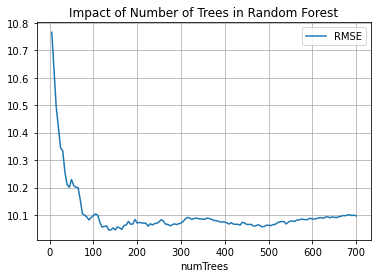

In [59]:
numTrees = ee.List.sequence(5, 700, 5)


def trees(t):
    rfRegression = ee.Classifier.smileRandomForest(numberOfTrees=t, seed=0).setOutputMode('REGRESSION').train(
    features= training, 
    classProperty= 'Percent_Tree_Cover', 
    inputProperties= predictionBands)
    
    rfRegressionTesting = testing.classify(rfRegression, 'y_hat')

    # // Calculate the RMSE for RF regression and print the result
    regression=rfRegressionTesting.map(set_sqError)
    regression = ee.FeatureCollection(regression)
    MSE = regression.reduceColumns(ee.Reducer.mean(),['sqError'])
    RMSE =  ee.Number(MSE.get('mean')).sqrt()        
    return RMSE


rmse_trees=numTrees.map(trees)
value_info = rmse_trees.getInfo()

# Extracting tree value for minimum RMSE
min_rmse=min(value_info)
print("Min RMSE =", min_rmse)

index=value_info.index(min(value_info))
trees_range = numTrees.getInfo()
min_trees =trees_range[index]
print("Min Trees =", min_trees)

# print(rmse_gama.getInfo())

# Plotting the interations

import pandas as pd
df =pd.DataFrame(value_info,columns=['RMSE'])
df['numTrees'] = numTrees.getInfo() 

ax =df.plot.line(x='numTrees', 
             y='RMSE',
             title= 'Impact of Number of Trees in Random Forest'
             )
ax.grid()

same for svr

Min RMSE = 9.936551386540803
Min Gamma = 6


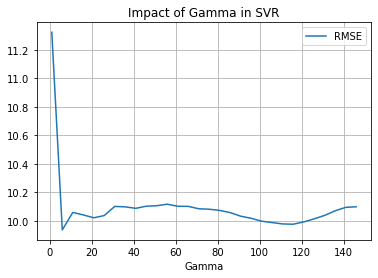

In [60]:
gamma_vals = ee.List.sequence(1, 150, 5)


def gammas(t):
    svrRegression = ee.Classifier.libsvm(svmType ='EPSILON_SVR',kernelType='RBF',gamma=t,cost=100).setOutputMode('REGRESSION').train(
      features= training, 
      classProperty= 'Percent_Tree_Cover', 
      inputProperties= predictionBands
    )
    
    svrRegressionTesting = testing.classify(svrRegression, 'y_hat');

    # // Calculate the RMSE for SVM regression and print the result
    regression=svrRegressionTesting.map(set_sqError)
    regression = ee.FeatureCollection(regression)
    MSE = regression.reduceColumns(ee.Reducer.mean(),['sqError'])
    RMSE =  ee.Number(MSE.get('mean')).sqrt()        
    return RMSE


rmse_gama=gamma_vals.map(gammas)
value_info = rmse_gama.getInfo()

# Extracting gamma value for minimum RMSE
min_rmse=min(value_info)
print("Min RMSE =", min_rmse)

index=value_info.index(min(value_info))
gamma_range = gamma_vals.getInfo()
min_gamma =gamma_range[index]
print("Min Gamma =", min_gamma)

# print(rmse_gama.getInfo())

# Plotting the interations
import pandas as pd
df =pd.DataFrame(value_info,columns=['RMSE'])
df['Gamma'] = gamma_vals.getInfo() 

ax =df.plot.line(x='Gamma', 
             y='RMSE',
             title= 'Impact of Gamma in SVR'
             )
ax.grid()

same for cart regression

Min RMSE = 10.564642576458905
Min Leaf = 21


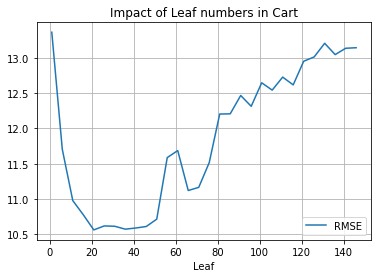

In [61]:
leaf_vals = ee.List.sequence(1, 150, 5)

def leafs(t):
    cartRegression = ee.Classifier.smileCart(minLeafPopulation=t).setOutputMode('REGRESSION').train(
    features= training, 
    classProperty= 'Percent_Tree_Cover', 
    inputProperties= predictionBands
    )

    cartRegressionTesting = testing.classify(cartRegression, 'y_hat');

    # // Calculate the RMSE for CART regression and print the result
    regression=cartRegressionTesting.map(set_sqError)
    regression = ee.FeatureCollection(regression)
    MSE = regression.reduceColumns(ee.Reducer.mean(),['sqError'])
    RMSE =  ee.Number(MSE.get('mean')).sqrt()        
    return RMSE


rmse_leaf=leaf_vals.map(leafs)
value_info = rmse_leaf.getInfo()

# Extracting gamma value for minimum RMSE
min_rmse=min(value_info)
print("Min RMSE =", min_rmse)

index=value_info.index(min(value_info))
leaf_range = leaf_vals.getInfo()
min_leaf =leaf_range[index]
print("Min Leaf =", min_leaf)

# print(rmse_gama.getInfo())

# Plotting the interations
import pandas as pd
df =pd.DataFrame(value_info,columns=['RMSE'])
df['Leaf'] = leaf_vals.getInfo() 

ax =df.plot.line(x='Leaf', 
             y='RMSE',
             title= 'Impact of Leaf numbers in Cart'
             )
ax.grid()

### Assignment

Recreate one notebook for Logan, UT, a dry climate with a variety of forest (natural to agriculture, Path 38, Row 31) and another notebook for New Orleans, Path 22 Row 39). Make sure your Cart, SVR and Random Forest in each notebook uses the tuned hyperparameters when discussing your found RMSE . Are the 4 models behaving similarly? Which model was able to model adequately Tree Percentage at Landsat resolution? Discuss it.